In [1]:
import zipfile
import os

In [2]:
!ls


output.zip  sample_data


In [3]:
zip_ref = zipfile.ZipFile('output.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('tmp/') #Extracts the files into the /tmp folder
zip_ref.close()

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
import pathlib

In [5]:
train_path = "./tmp/output/train"
test_path  = "./tmp/output/test"
val_path = "./tmp/output/val"

In [6]:
import os
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
%matplotlib inline

In [7]:
image_shape = (100,100,3)
epochs = 8
batch_size = 64

In [8]:
def bitwise_invert(image):
    temp = tf.image.rgb_to_grayscale(255 -
    image)
    # temp = np.abs(255 - temp)
    temp = tf.image.grayscale_to_rgb(temp)
    #temp = np.abs(255 - image)
    return temp


traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1.0/255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                              zoom_range=0.1,
                             fill_mode='nearest',
                             preprocessing_function=bitwise_invert
                              )

testdata_gen=ImageDataGenerator(
                                rescale=1.0/255,
                                preprocessing_function=bitwise_invert
                             )

valdatagen = ImageDataGenerator(
                            rescale=1.0/255,
                            preprocessing_function=bitwise_invert
                    )

In [9]:
train_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                           shuffle=True,
                                           seed=3301)

test_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                color_mode = 'rgb',
                                            shuffle=False)
val_set = valdatagen.flow_from_directory(val_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                            shuffle=True )

Found 7199 images belonging to 16 classes.
Found 915 images belonging to 16 classes.
Found 894 images belonging to 16 classes.


In [10]:
class_labels = list(train_set.class_indices.keys())
num_classes = len(class_labels)
print(class_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']


(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


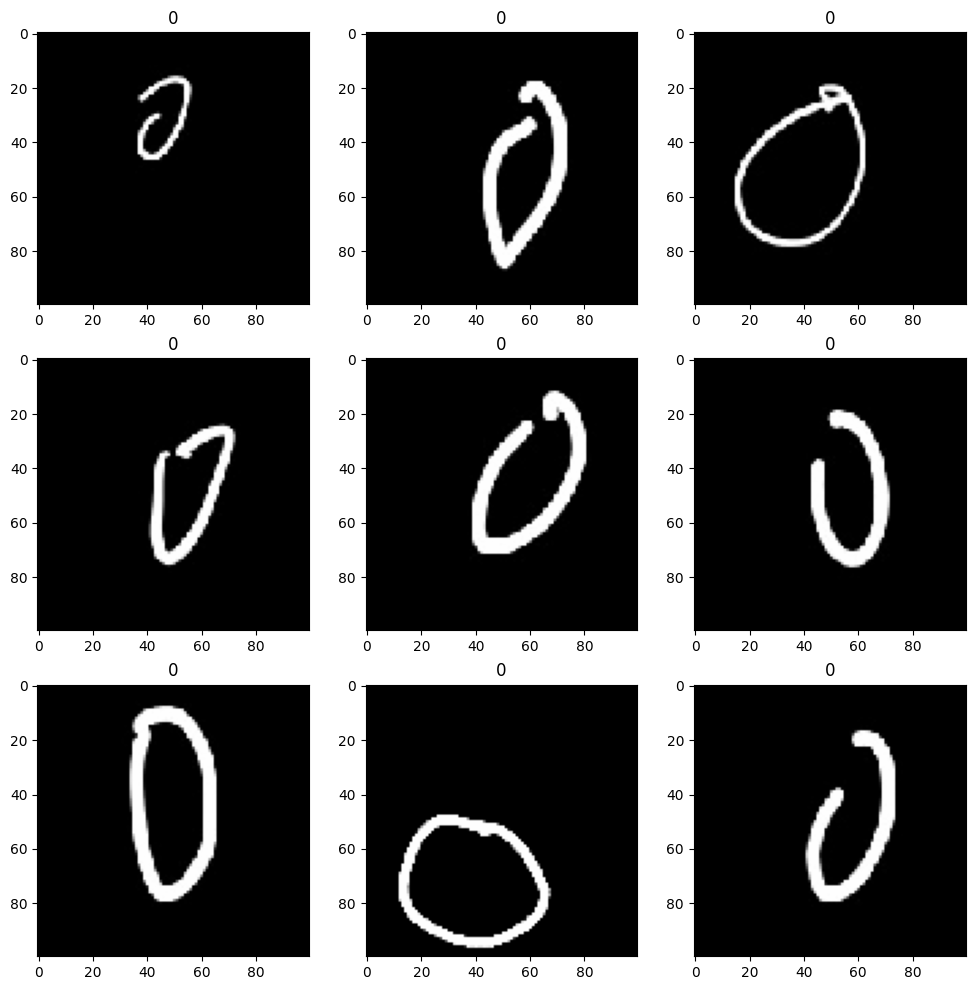

In [11]:
plt.figure(figsize=(12, 12))
for images, labels in test_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        print(image.shape)
        label = class_labels[np.argmax(labels[i])]
        #plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        plt.imshow(image)
        plt.title(label)
    break

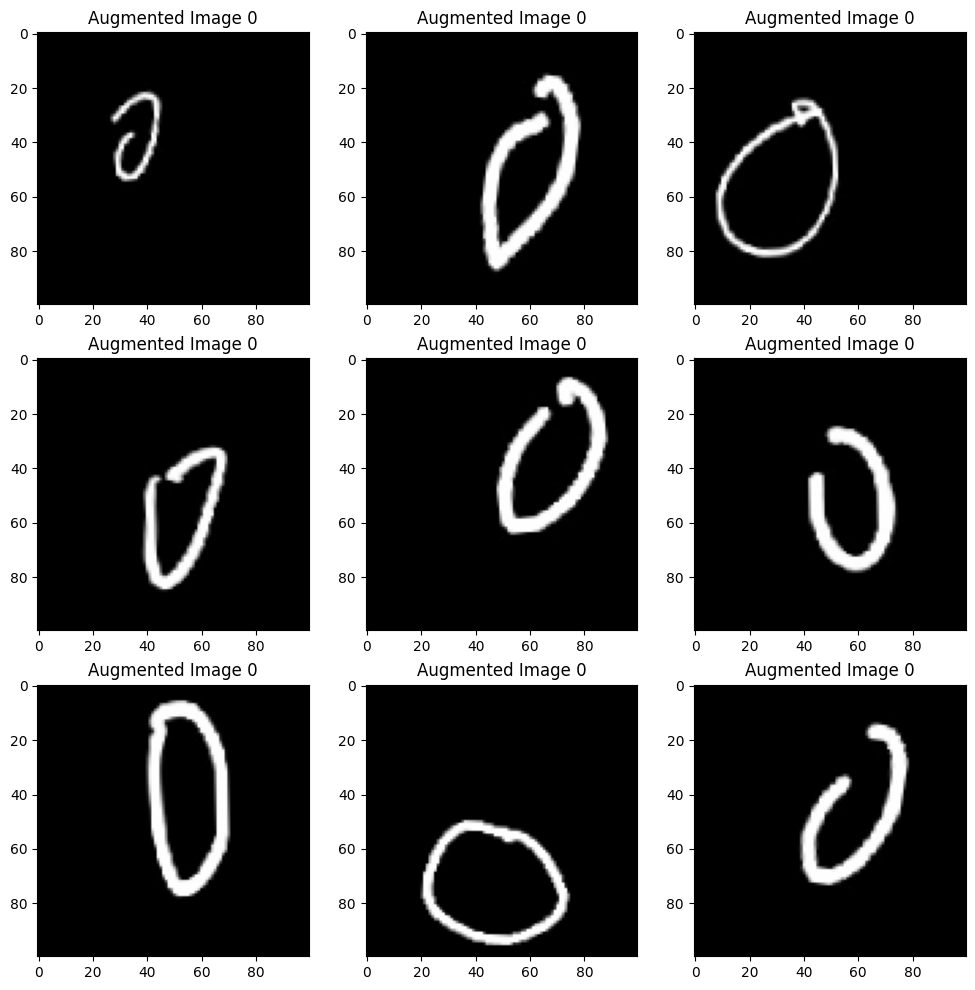

In [12]:
plt.figure(figsize=(12, 12))
for img_batch,label_batch in train_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]
        tx_img = traindata_gen.random_transform(image)
        plt.imshow(tx_img, cmap='gray', vmin=0, vmax=1)
        plt.title('Augmented Image ' + label)

    break

In [13]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=image_shape, pooling='max', weights='imagenet')
base_model.trainable = True
x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

x=Dropout(rate=.3, seed=123)(x)

output=Dense(num_classes, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=2, verbose=1,restore_best_weights=True)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']           

In [15]:
result = model.fit(
  train_set,
  epochs=epochs,
  validation_data=val_set,
  callbacks=[early_stop]

)

Epoch 1/8
113/113 [==============================] - 95s 514ms/step - loss: 11.9986 - accuracy: 0.8905 - val_loss: 8.1197 - val_accuracy: 0.5459
Epoch 2/8
113/113 [==============================] - 55s 486ms/step - loss: 4.2984 - accuracy: 0.9781 - val_loss: 3.5575 - val_accuracy: 0.6074
Epoch 3/8
113/113 [==============================] - 55s 483ms/step - loss: 1.5663 - accuracy: 0.9874 - val_loss: 1.5034 - val_accuracy: 0.8277
Epoch 4/8
113/113 [==============================] - 55s 483ms/step - loss: 0.6000 - accuracy: 0.9887 - val_loss: 0.9746 - val_accuracy: 0.7864
Epoch 5/8
113/113 [==============================] - 56s 493ms/step - loss: 0.2558 - accuracy: 0.9901 - val_loss: 0.5890 - val_accuracy: 0.8792
Epoch 6/8
113/113 [==============================] - 55s 484ms/step - loss: 0.1309 - accuracy: 0.9918 - val_loss: 0.6957 - val_accuracy: 0.8322
Epoch 7/8
113/113 [==============================] - 55s 486ms/step - loss: 0.0836 - accuracy: 0.9944 - val_loss: 0.2181 - val_accuracy

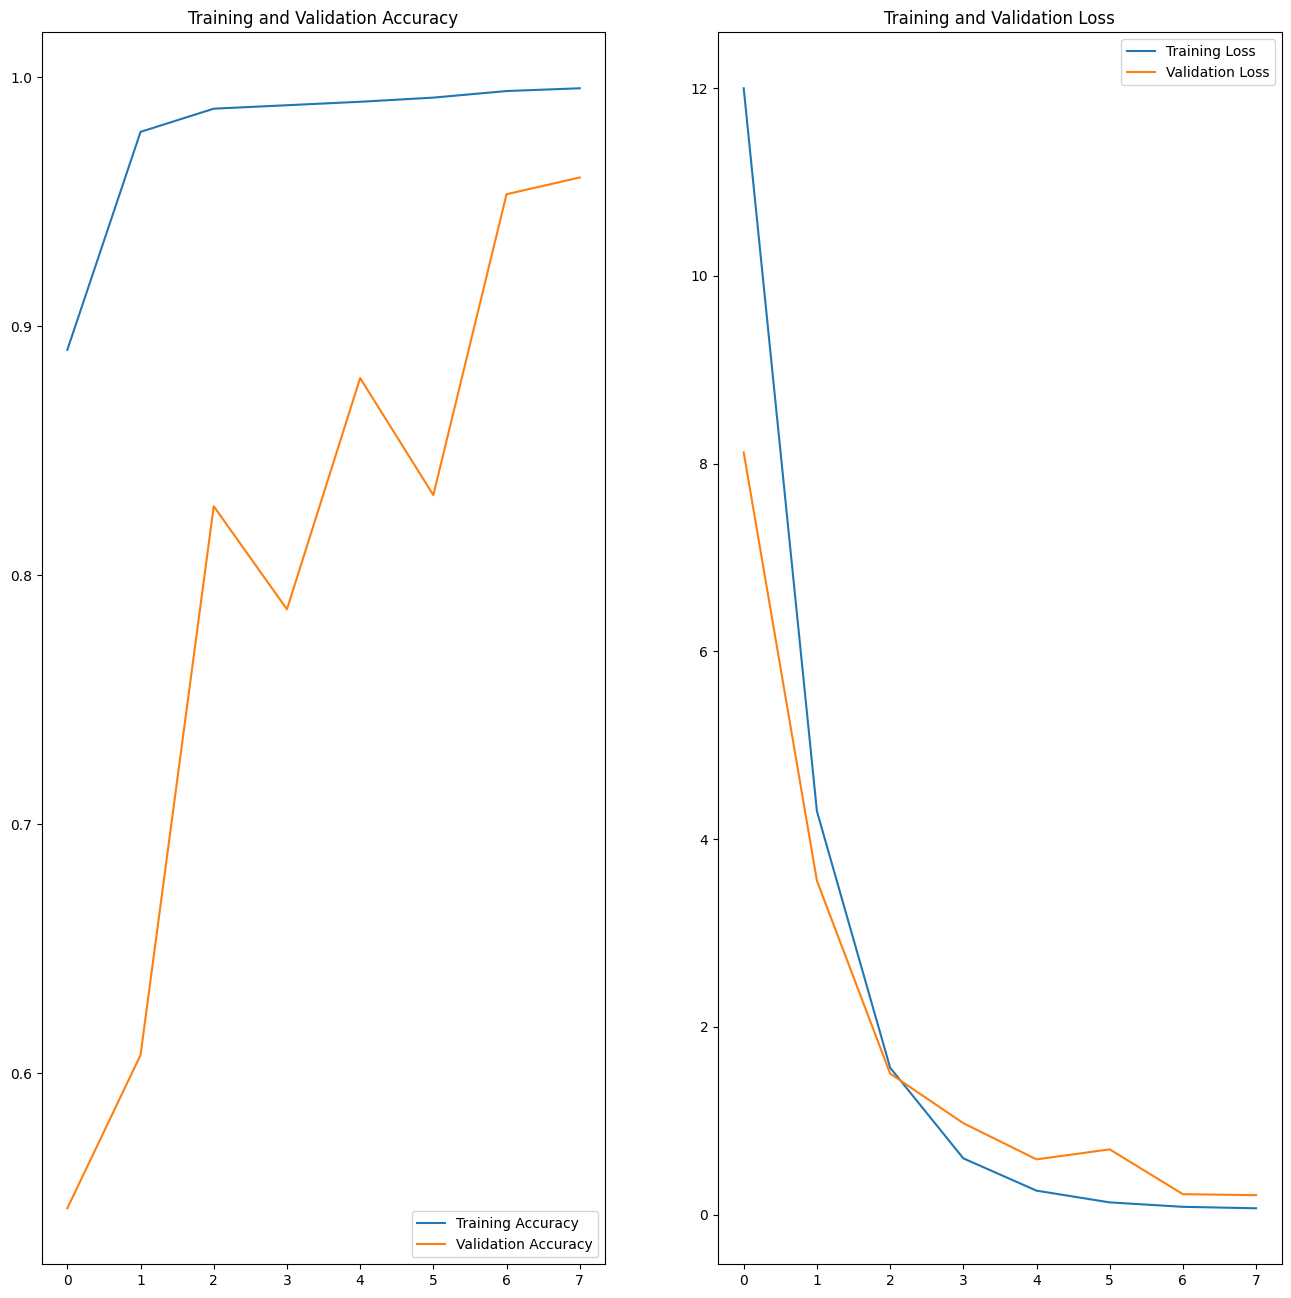

In [16]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

from sklearn.metrics import  classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

15/15 [==============================] - 8s 339ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.89      1.00      0.94        57
           2       1.00      0.93      0.96        44
           3       0.93      0.91      0.92        55
           4       1.00      0.96      0.98        54
           5       1.00      0.89      0.94        44
           6       1.00      0.97      0.98        59
           7       0.94      0.93      0.93        54
           8       0.89      1.00      0.94        56
           9       1.00      0.86      0.92        56
         add       0.97      1.00      0.98        61
         dec       1.00      0.98      0.99        63
         div       1.00      1.00      1.00        63
          eq       1.00      0.95      0.98        64
         mul       1.00      0.97      0.98        59
         sub       0.96      1.00      0.98        66

    accuracy             

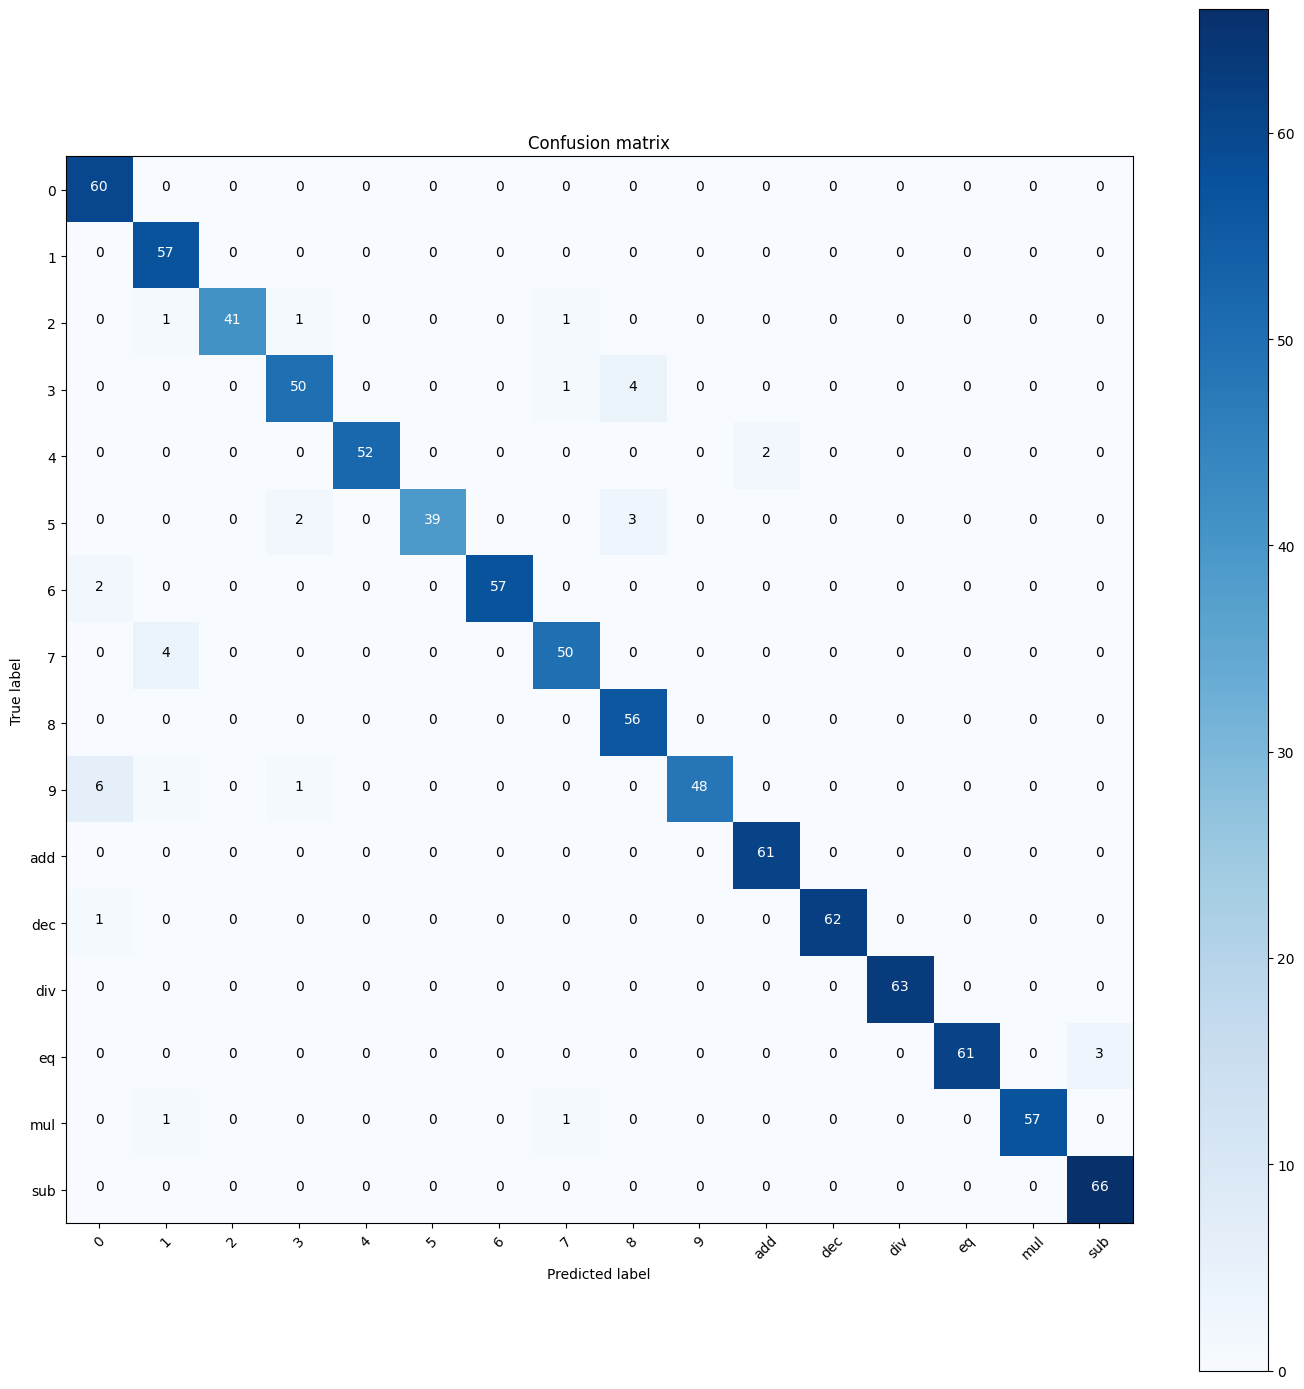

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
# plot the confusion matrix

plt.figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = class_labels)